### Optimización del modelo seleccionado

Después de haber desarrollado varios modelos predictivos (incluyendo DummyClassifier, Random Forest, Decision Tree, LightGBM, y XGBoost,Gradient Boosting, AdaBoost,LogisticRegression,GaussianNB y SVC) y haber evaluado sus rendimientos a través de diversas métricas (como Precisión, Recall, F1, ROC-AUC score...), el siguiente paso es analizarlos comparativamente para determinar el más adecuado. Este modelo seleccionado será posteriormente afinado mediante validación cruzada para identificar los parámetros óptimos. El proceso se puede estructurar de la siguiente manera:

1. Preparación del entorno incluyendo la importación de bibliotecas necesarias, funciones y datos
2. Análisis comparativo y elección del modelo más apropiado.
3. Ajuste fino del modelo elegido a través de la validación cruzada.
4. Realización de predicciones y evaluación detallada del modelo.
5. Guardado y exportación del modelo finalizado para su uso futuro.

Importamos las librerías necesarias.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, fbeta_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
import scikitplot as skplt
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

Definimos la función evaluate_model que proporciona una evaluación general del redemiento de un modelo de clasificación.

Aporta la siguiente información:

1. ROC-AUC Score: Si se proporcionan las probabilidades de predicción (ypred_proba), la función calcula y muestra el puntaje ROC-AUC, que es una medida de la capacidad del modelo para distinguir entre clases.

2. Accuracy: Calcula y muestra la precisión (Accuracy) del modelo, que es la proporción de predicciones correctas entre el total de predicciones.

3. Classification Report: Muestra un informe de clasificación que incluye varias métricas como precisión, recall, puntuación F1, etc., para cada clase.

In [2]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))

Importamos los pickles que necesitamos. Los datos de entrenamiento tienen undersampling mientras que los datos del test están desbalanceados.
El test nunca ha sido tocado y la proporción de 0s y 1s en la que venía originariamente en el dataset.

In [3]:
with open('../data/X_train_undersampled.pickle', 'rb') as file:
    X_train_undersampled = pickle.load(file)

with open('../data/y_train_undersampled.pickle', 'rb') as file:
    y_train_undersampled = pickle.load(file)
    
with open('../data/X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('../data/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


Ahora elaboraremos un diccionario para poder realizar una comparativa entre los diferentes modelos y posteriormente lo convertiremos en dataframe.

In [4]:

models_metrics = {
    'Modelo': [
        'Base (Dummy)', 'LogisticRegression', 'GaussianNB', 'SVC', 
        'DecisionTreeClassifier', 'RandomForestClassifier', 
        'LGBMClassifier', 'AdaBoostClassifier', 
        'GradientBoostingClassifier', 'XGBClassifier'
    ],
    'Accuracy': [
        0.98897, 0.97532, 0.79098, 0.98438, 
        0.91316, 0.98199, 0.97469, 0.97272, 
        0.97850, 0.97052
    ],
    'Precision(0)': [
        0.99, 0.99, 1.00, 0.99, 
        0.99, 0.99, 0.99, 0.99, 
        0.99, 0.99
    ],
    'Precision(1)': [
        0.00, 0.15, 0.04, 0.21, 
        0.05, 0.21, 0.18, 0.17, 
        0.19, 0.16
    ],
    'Recall(0)': [
        1.00, 0.98, 0.79, 0.99, 
        0.92, 0.99, 0.98, 0.98, 
        0.99, 0.98
    ],
    'Recall(1)': [
        0.00, 0.28, 0.73, 0.15, 
        0.37, 0.23, 0.35, 0.37, 
        0.30, 0.38
    ],
    'F1(0)': [
        0.99, 0.99, 0.88, 0.99, 
        0.95, 0.99, 0.99, 0.99, 
        0.99, 0.98
    ],
    'F1(1)': [
        0.00, 0.20, 0.07, 0.17, 
        0.09, 0.22, 0.23, 0.23, 
        0.24, 0.22
    ]
}

models_comparison_df = pd.DataFrame(models_metrics)

models_comparison_df


,Modelo,Accuracy,Precision(0),Precision(1),Recall(0),Recall(1),F1(0),F1(1)
0,Base (Dummy),0.98897,0.99,0.00,1.00,0.00,0.99,0.00
1,LogisticRegression,0.97532,0.99,0.15,0.98,0.28,0.99,0.20
2,GaussianNB,0.79098,1.00,0.04,0.79,0.73,0.88,0.07
3,SVC,0.98438,0.99,0.21,0.99,0.15,0.99,0.17
4,DecisionTreeClassifier,0.91316,0.99,0.05,0.92,0.37,0.95,0.09
5,RandomForestClassifier,0.98199,0.99,0.21,0.99,0.23,0.99,0.22
6,LGBMClassifier,0.97469,0.99,0.18,0.98,0.35,0.99,0.23
7,AdaBoostClassifier,0.97272,0.99,0.17,0.98,0.37,0.99,0.23
8,GradientBoostingClassifier,0.97850,0.99,0.19,0.99,0.30,0.99,0.24
9,XGBClassifier,0.97052,0.99,0.16,0.98,0.38,0.98,0.22


Viendo esta tabla finalmente nos decidimos por el LGBM. A continuación expondremos el porqué de nuestra elección:

Al evaluar las opciones para un modelo de clasificación de fraude, donde es crítico detectar la clase positiva que representa el fraude ('1'), la deicisión final, observando la tabla y las métricas ha quedado entre tres modelos: LGBMClassifier, AdaBoostClassifier y GradientBoostingClassifier. Cada uno de estos modelos tiene sus mértitos y han demostrado ser competentes en muchas tareas de clasificación. Sin embargo, para este escenario específico, el LGBMClassifier es la opción final debido a varias razones clave.

Primero, el LGBMClassifier tiene un recall para la clase '1' que, aunque no es el más alto de todos los modelos, es sustancialmente equilibrado en relación con su precisión (Precision(1)). Este balance es crucial en la detección de fraude, donde no solo es importante detectar tantos fraudes reales como sea posible (alto recall), sino también mantener una cantidad razonable de falsas alarmas (es decir 0s que se clasifican como 1s).

En segundo lugar, aunque el GradientBoostingClassifier ofrece el puntaje F1 más alto para la clase '1', el margen de mejora en el recall del LGBMClassifier puede considerarse más valioso, dado que el recall es un factor crítico en la detección de fraude. Es preferible detectar una mayor cantidad de transacciones fraudulentas reales, incluso si eso significa revisar más transacciones legítimas que se marcan erróneamente como fraudulentas. Por lo tanto llegados a este punto descartamos el GradientBoosting ya que estamos interesados en capturar el mayor número de 1s posible.

Por último, la eficiencia operativa del LGBMClassifier es importante. A pesar de que AdaBoostClassifier comparte un recall similar para la clase '1', LGBM es conocido por su rendimiento computacional rápido y eficiente, lo cual es esencial para procesar grandes volúmenes de transacciones en tiempo real. Debido a esto, si nos quedaban dudas aquí es donde el LGBM gana por completo la partida al AdaBoosting, en su eficiencia computacional.

Por tanto, teniendo en cuenta la necesidad de un equilibrio adecuado entre el recall y la precisión, junto con la eficiencia operativa, el LGBMClassifier se posiciona como la elección preferente. Su capacidad para proporcionar una detección fiable y su rendimiento ágil en el manejo de datos masivos lo convierten en el candidato ideal para implementar en un sistema de detección de fraude efectivo


Procedemos a hacer el modelo final con el LGBM.

En primer lugar elaboramos un pipeline que contiene el clasificador. Si no hubieramos preprocesado los datos previamente podriamos incluir el preprocesador que hemos creado en el pipeline y preprocesar los datos antes de utilizar el clasificador. Sin embargo como ya hemos preprocesado los datos nos saltamos esa parte.

Posteriormente realizamos la optimización del modelo LGBM. Utilizando la técnica de Grid Search, se explora sistemáticamente una variedad de configuraciones del modelo LGBMClassifier para determinar cuál combinación de parámetros mejora su desempeño. El resultado es un modelo bien ajustado, adaptado específicamente a las peculiaridades y complejidades de nuestros datos de fraude.

Posteriormente entrenamos con nuestros datos de entrenamiento.

In [5]:
LGBM_model = Pipeline([
    ('classifier', LGBMClassifier(random_state=12345, force_col_wise=True))
])

In [6]:
param_grid = {
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [4, 6],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__min_child_samples': [1, 5, 10]
}
CV= GridSearchCV(estimator=LGBM_model, param_grid=param_grid, cv=5, n_jobs=-1)


In [7]:
CV.fit(X_train_undersampled, y_train_undersampled)

[LightGBM] [Info] Number of positive: 8823, number of negative: 79407
[LightGBM] [Info] Total Bins 3366
[LightGBM] [Info] Number of data points in the train set: 88230, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100000 -> initscore=-2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        LGBMClassifier(force_col_wise=True,
                                                       random_state=12345))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.7, 0.8, 0.9],
                         'classifier__learning_rate': [0.1, 0.01],
                         'classifier__max_depth': [4, 6],
                         'classifier__min_child_samples': [1, 5, 10],
                         'classifier__n_estimators': [50, 100, 150],
                         'classifier__subsample': [0.7, 0.8, 0.9]})

Guardamos el modelo entrenado en un pickle y lo abrimos para no tener que entrenar el modelo cada vez que ejecutemos el notebook.

In [8]:
with open('../models/LGBM_entrenadoUndersampling.pkl', 'wb') as file:
    pickle.dump(CV, file)

In [9]:
with open('../models/LGBM_entrenadoUndersampling.pkl', 'rb') as file:
    LGBM_model = pickle.load(file)

Ahora predecimos y evaluamos el modelo con los datos con los que hemos entrenado para posteriormente al compararlo con el test comprobar si existe overfitting en nuestro modelo o si por el contrario es capaz de generalizar bien a nuestros datos. Para ellos compararemos las métricas que obtengamos con las obtenidas posteriormente en el test.

In [10]:
pred = CV.best_estimator_.predict(X_train_undersampled)
pred_proba = CV.best_estimator_.predict_proba(X_train_undersampled)

Obtenemos los resultados.

In [11]:
evaluate_model(y_train_undersampled, pred,pred_proba)

ROC-AUC score of the model: 0.9172861397160172
Accuracy of the model: 0.9255922021987986

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     79407
           1       0.75      0.39      0.51      8823

    accuracy                           0.93     88230
   macro avg       0.84      0.69      0.73     88230
weighted avg       0.92      0.93      0.91     88230




Finalmente hacemos lo mismo con el test. Utilizamos el mejor modelo encontrado por GridSearchCV para realizar las prediciones sobre X_test.

Calculamos tanto pred como pred_proba. Pred nos dará la decisión final del modelo, mientras que pred_proba una medida de confianza o incertidumbre del modelo sobre cada una de sus predicciones, es decir obtendremos una probabilidad para la clase 0 y otra para la clase 1 para cada instancia.

In [12]:
pred = CV.best_estimator_.predict(X_test)
pred_proba = CV.best_estimator_.predict_proba(X_test)

Finalmente analizamos los resultados del modelo utilizando la función evaluate_model.

In [13]:
evaluate_model(y_test, pred,pred_proba)

ROC-AUC score of the model: 0.8957341796424352
Accuracy of the model: 0.975405

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    197794
           1       0.18      0.35      0.24      2206

    accuracy                           0.98    200000
   macro avg       0.59      0.66      0.61    200000
weighted avg       0.98      0.98      0.98    200000




Podemos analizar las metricas obtenidas de la siguiente manera:

*ROC-AUC Score*: 0.89573

El área bajo la curva (ROC-AUC) es una medida de la eficacia de un modelo para distinguir entre las clases. Un valor de 0.89573 es bastante alto y sugiere que el modelo tiene una buena capacidad de diferenciar entre transacciones fraudulentas y legítimas.

*Accuracy*: 0.975405

La precisión global del modelo es de aproximadamente el 97.54%, lo que indica que un alto porcentaje de las predicciones totales son correctas.

*Classification Report*:

Precision para la clase '0' (No Fraude): 0.99

Esto significa que cuando el modelo predice que una transacción no es fraude, tiene razón el 99% de las veces.

Recall para la clase '0': 0.98

De todas las transacciones que realmente no son fraudulentas, el modelo identifica correctamente el 98% de ellas.

F1-score para la clase '0': 0.99

El puntaje F1 es una media armónica de la precisión y el recall. Un puntaje de 0.99 es excelente y sugiere que el modelo es muy efectivo en la identificación de transacciones no fraudulentas.

Precision para la clase '1' (Fraude): 0.18

Cuando el modelo predice fraude, solo es correcto el 18% de las veces. Esto significa que hay un alto número de falsos positivos (transacciones legítimas marcadas incorrectamente como fraude).

Recall para la clase '1': 0.35

El modelo es capaz de identificar el 35% de todas las transacciones fraudulentas reales. Aunque este valor no es muy alto, es importante recordar que en la detección de fraude, incluso un bajo nivel de detección puede ser valioso si se identifican fraudes significativos o de gran valor.

F1-score para la clase '1': 0.24

El puntaje F1 para la clase '1' es bastante bajo, lo que refleja la dificultad de equilibrar la precisión y el recall para las instancias de fraude. Esto es típico en situaciones donde la clase positiva es mucho menos común, como es nuestro caso.

**Justificación de la ausencia de overfitting**

Tras un análisis detallado de las métricas de rendimiento del modelo LGBMClassifier, entrenado en un conjunto de datos balanceado mediante undersampling y evaluado tanto en este conjunto como en un conjunto de prueba desbalanceado, llegamos a la conclusión de que no hay evidencia de overfitting significativo. A continuación se detallan las razones clave de esta conclusión:

Estabilidad del ROC-AUC.El modelo muestra una leve disminución en el score de ROC-AUC de 0.917 en el conjunto de entrenamiento a 0.896 en el conjunto de prueba. Esta pequeña variación indica que el modelo mantiene su capacidad de discriminación entre clases positivas y negativas en datos nuevos, lo cual es un fuerte indicador de buena generalización.

Rendimiento consistente en la clase mayoritaria.En ambos conjuntos, el modelo exhibe un alto rendimiento en la identificación de la clase mayoritaria (clase '0'), con una precisión y un recall elevados. Esto sugiere que el modelo ha aprendido patrones generales que son aplicables tanto a los datos vistos como a los no vistos, reflejando una buena adaptabilidad.

La disminución en la precisión para la clase minoritaria (clase '1') en el conjunto de prueba, en comparación con el conjunto de entrenamiento balanceado, puede atribuirse en gran medida al hecho de que el modelo fue evaluado inicialmente en un conjunto de datos balanceado. La primera evaluación mostró un rendimiento optimista para la clase minoritaria debido al equilibrio artificial de las clases. Al pasar a un conjunto de prueba desbalanceado, que refleja mejor la distribución real de las clases, se observa una disminución en la precisión para esta clase. Esta variación refleja la necesidad de mejorar la clasificación de la clase minoritaria en contextos más realistas y no es necesariamente un indicador de overfitting.

En resumen, los resultados de las evaluaciones muestran que el modelo LGBMClassifier tiene un buen desempeño general y mantiene una capacidad de generalización en el conjunto de prueba. La disminución en la precisión para la clase minoritaria en el conjunto de prueba es más un reflejo de los desafíos de clasificar en un entorno desbalanceado y de las limitaciones de la evaluación inicial en datos balanceados, que un signo de sobreajuste. Por lo tanto, el modelo no muestra signos claros de overfitting, aunque hay áreas de mejora, especialmente en el manejo del desequilibrio de clases.

Un rendimiento más bajo en el conjunto de prueba (desbalanceado) que en el de entrenamiento (balanceado) es común, especialmente en problemas con desequilibrio de clases. Esto no necesariamente indica sobreajuste, sino que puede reflejar la dificultad del modelo para manejar clases minoritarias en un entorno desbalanceado.

Procedemos a realizar la Matriz de confusión, la curva roc, la curva lift y la curva de ganancia.

Confusion matrix, without normalization
[[194318   3476]
 [  1443    763]]


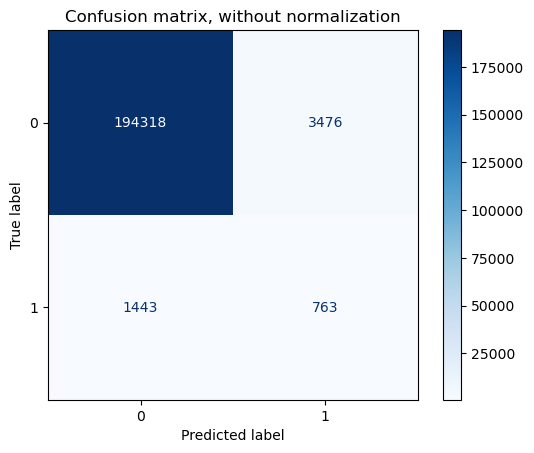

Normalized confusion matrix
[[0.98242616 0.01757384]
 [0.65412511 0.34587489]]


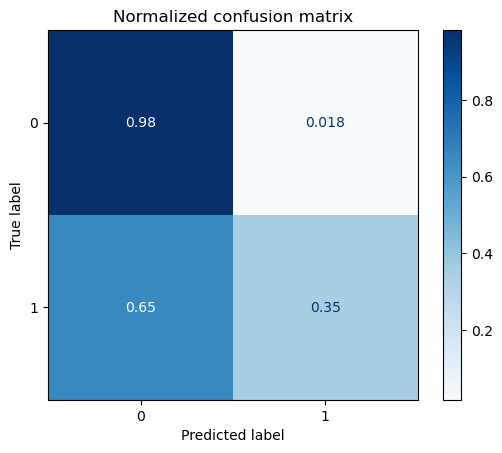

In [14]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        LGBM_model, X_test, y_test, 
        display_labels=LGBM_model.classes_, 
        cmap=plt.cm.Blues, 
        normalize=normalize
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()

En la matriz de confusión sin normalizar (parte superior), los valores muestran el número de predicciones en cada categoría:

Verdaderos Negativos (TN): 194.318 - El modelo predijo correctamente la clase negativa (no fraude) en esta cantidad de casos.

Falsos Positivos (FP): 3.476 - El modelo predijo incorrectamente la clase positiva (fraude) en casos que en realidad eran negativos (no fraude).

Falsos Negativos (FN): 1.443 - El modelo no detectó la clase positiva (fraude) y la marcó incorrectamente como negativa (no fraude).

Verdaderos Positivos (TP): 763 - El modelo identificó correctamente la clase positiva (fraude) en esta cantidad de casos.

La matriz de confusión normalizada (parte inferior) muestra la misma información pero como proporciones del total de predicciones para cada clase real.

Esto proporciona una vista clara del rendimiento del modelo, indicando una alta precisión en la identificación de no fraudes y una capacidad moderada para identificar correctamente los fraudes

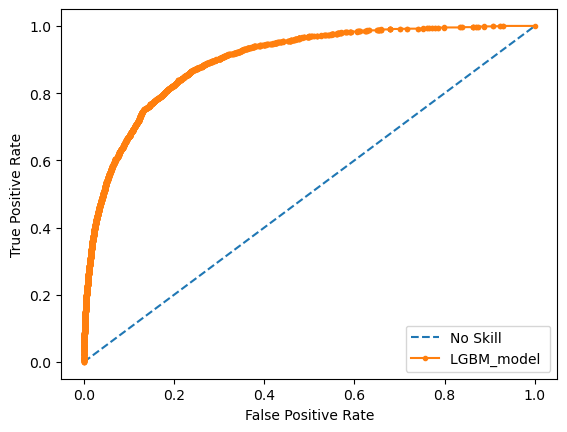

In [15]:
yhat = pred_proba[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, yhat)

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBM_model ')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

Aquí podemos ver nuestra curva Roc que representa gráficamente el rendimiento de nuestro modelo. 
La línea naranja representa el modelo LGBM. Cuanto más se acerque esta línea hacia la esquina superior izquierda (donde TPR es 1 y FPR es 0), mejor será el modelo para discriminar entre las dos clases, en este caso, fraude y no fraude.

La línea punteada azul representa un clasificador sin habilidad, conocido como "No Skill" classifier. Este clasificador sirve como punto de referencia y simplemente predice la clase mayoritaria en todo momento, sin tener en cuenta las características de entrada.

La curva ROC realizada indica que el modelo LGBM tiene un buen rendimiento, ya que se aleja de la línea de "No Skill" y se aproxima hacia la esquina superior izquierda del gráfico. Esto sugiere que el modelo es capaz de distinguir con una eficacia considerable entre las transacciones legítimas y las fraudulentas.

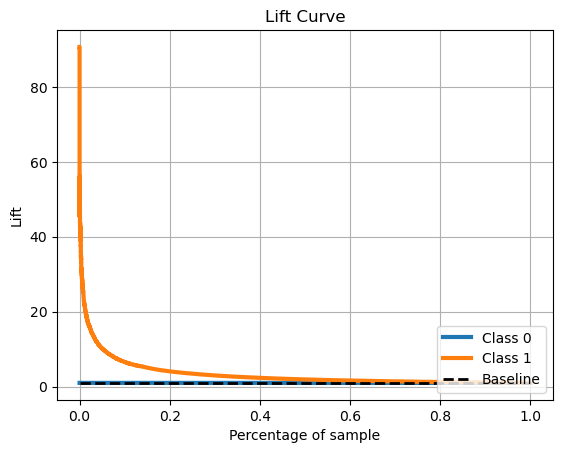

In [19]:
skplt.metrics.plot_lift_curve(y_test, pred_proba)
plt.show()

La curva lift muestra cuánto más efectivo es el modelo en la predicción de una clase específica en comparación con una selección aleatoria. La línea horizontal punteada representa la línea de base, que es el rendimiento que se obtendría si las predicciones se hicieran al azar. Las líneas azul y naranja representan el desempeño del modelo para cada clase (Clase 0 y Clase 1).

Para la clase 0(No fraude) la curva parece permanecer muy cerca de la línea de base, lo cual indica que para la Clase 0, el modelo no está proporcionando mucha mejora en comparación con decisiones aleatorias o un modelo sin información. La proximidad de la curva de elevación de la Clase 0 a la línea de base es un fenómeno normal y esperado en contextos donde se trabaja con datos altamente desbalanceados, como es nuestro caso.  La Clase 0, es mucho más prevalente. En estos casos, la mayoría de las predicciones serán de la clase mayoritaria por defecto, y por lo tanto, un modelo sin habilidad predictiva – que prediga siempre la clase mayoritaria – tendrá automáticamente una alta precisión.

Esta es la curva más importante para la detección de fraude, ya que la Clase 1  representa los casos de fraude, que son la minoría. La curva de la Clase 1 muestra un "lift" muy alto al principio, lo que significa que el modelo es muy efectivo en identificar correctamente los casos de fraude más probables en un pequeño porcentaje de la muestra total. Después de este pico inicial, la curva desciende rápidamente hacia la línea de base, lo que indica que a medida que se incluyen más casos en la muestra, la efectividad del modelo para identificar casos adicionales de fraude disminuye.

La elevación inicial muy alta seguida de un descenso rápido es típica de los conjuntos de datos con una clase muy desbalanceade. El modelo está haciendo un buen trabajo al clasificar los casos más evidentes de fraude primero, lo cual es valioso en situaciones prácticas donde los recursos de investigación son limitados y se quiere priorizar el trabajo en los casos más sospechosos.

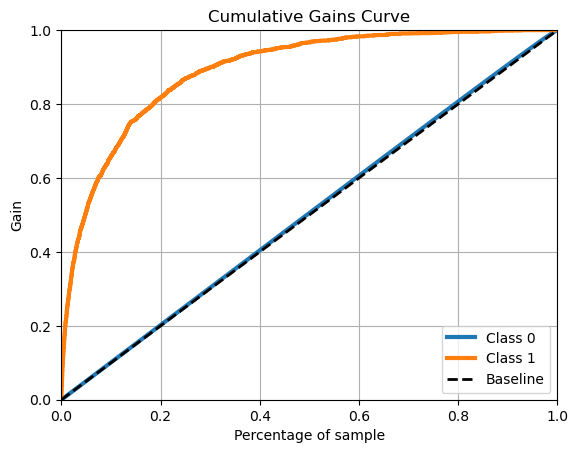

In [17]:
skplt.metrics.plot_cumulative_gain(y_test, pred_proba)
plt.show()

La curva de ganancia acumulativa ilustra la efectividad del modelo al clasificar casos positivos comparada con un modelo de clasificación aleatoria (línea de base). En el eje Y, tenemos el "Gain", que representa la proporción de casos positivos capturados por el modelo hasta cierto porcentaje del conjunto de datos probado, el cual se muestra en el eje X.

La línea de base, marcada con una línea punteada negra, representa un modelo sin capacidad predictiva que simplemente asigna clases al azar. Idealmente, queremos que la curva de nuestra clase de interés (en este caso, la Clase 1) esté lo más lejos posible de esta línea de base y lo más cerca posible del borde superior izquierdo del gráfico.

La línea azul representa la clase negativa (Clase 0), y parece seguir de cerca la línea de base, esto es debido a que la clase negativa es la dominante en el conjunto de datos y un modelo que simplemente predijera 'no fraude' para todas las instancias tendría un rendimiento naturalmente alto debido a la prevalencia de esta clase. En resumen, el modelo no solo está haciendo un trabajo aleatorio, sino que es bastante preciso en la identificación de la clase negativa, como lo demuestran tus métricas de clasificación.

La línea naranja representa la clase positiva (Clase 1), que es nuestro principal interés en la detección de fraude. Esta línea se eleva rápidamente y se mantiene por encima de la línea de base, lo que indica que el modelo es bastante eficaz en la identificación de casos positivos.

La curva para la Clase 1 demuestra que el modelo tiene una buena capacidad para identificar los casos positivos temprano en el orden de clasificación. Por ejemplo, si seleccionamos el top 20% de las muestras según la puntuación del modelo, capturaríamos una gran proporción de todos los casos positivos (fraudes) presentes en el conjunto de datos completo. Esto es particularmente útil para priorizar las transacciones más sospechosas de fraude para una revisión más detallada.



En el próximo notebook analizaremos la interpretabilidad del modelo.